# <u>**Лабораторная работа 3.**</u>
# Решающее дерево
## *Задача классификации*



### Импорт необходимых библиотек

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [18]:
data = pd.read_csv("../WineQT.csv")  

### Разделение на признаки и целевую переменную

In [19]:
X = data.drop(columns=["quality"])  # Все кроме качества
y = data["quality"]  # Качество (целевая)

### Подготовка данных, обучение и оценка качества модели

Accuracy: 0.6997084548104956
F1-Score: 0.7282321899736148
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.67      0.66       152
           1       0.73      0.72      0.73       191

    accuracy                           0.70       343
   macro avg       0.70      0.70      0.70       343
weighted avg       0.70      0.70      0.70       343



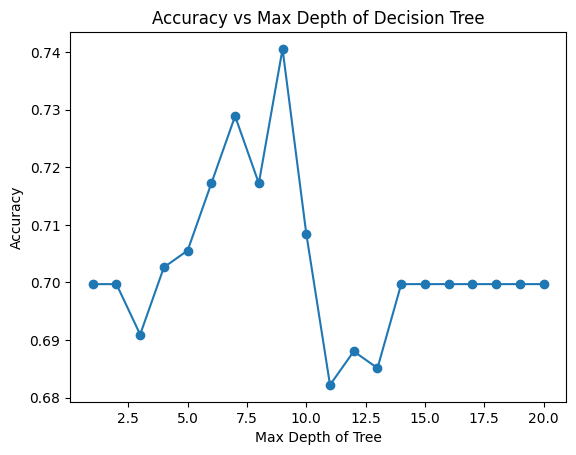

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt

# Бинаризация целевой переменной для классификации (например, хорошее/плохое качество)
y = (y >= 6).astype(int)  # Вино хорошего качества, если оценка >= 6

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Масштабирование данных (не обязательно для деревьев, но оставим, чтобы использовать тот же код)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Обучение модели решающего дерева
tree = DecisionTreeClassifier(random_state=42, max_depth=None)  # max_depth=None означает отсутствие ограничения глубины
tree.fit(X_train, y_train)

# Предсказания
y_pred = tree.predict(X_test)

# Оценка качества модели
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("F1-Score:", f1)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Анализ зависимости качества от глубины дерева (параметр max_depth)
max_depths = range(1, 21)
accuracies = []

for depth in max_depths:
    tree = DecisionTreeClassifier(random_state=42, max_depth=depth)
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))

# Построение графика зависимости
plt.plot(max_depths, accuracies, marker='o')
plt.xlabel('Max Depth of Tree')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Max Depth of Decision Tree')
plt.show()


## **Улучшенный бейзлайн**











### *Создание полиномиальных признаков*: Полиномиальные признаки создаются с помощью функции PolynomialFeatures. Эта функция возводит исходные признаки в степень до указанной степени (в данном случае 2), что позволяет добавлять нелинейность в данные и потенциально улучшить производительность модели.

In [21]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)  

###    *Обработка дисбаланса классов через SMOTE*: Метод SMOTE используется для создания синтетических примеров меньшинства класса, чтобы сбалансировать классы перед обучением модели. Это важно, так как дисбаланс классов может привести к смещению модели в сторону большинства класса.

In [22]:
# Обработка дисбаланса классов через SMOTE
smote = SMOTE(random_state=42)
X_train_poly, y_train_balanced = smote.fit_resample(X_train_poly, y_train)

###    *Задание параметров для GridSearchCV*: Параметры для оптимизации гиперпараметров модели задаются в словаре param_grid.


In [24]:
param_grid = {
    'max_depth': [None, 5, 10, 15, 20],  # Глубина дерева
    'min_samples_split': [2, 5, 10],    # Минимальное число выборок для разделения узла
    'min_samples_leaf': [1, 2, 5],      # Минимальное число выборок в листе
    'criterion': ['gini', 'entropy']    # Критерий разбиения
}

# Инициализируем классификатор решающего дерева
tree = DecisionTreeClassifier(random_state=42)

###    Оптимизация модели с помощью GridSearchCV: Для нахождения наилучших значений гиперпараметров используется кросс-валидация с 5 фолдами (cv=5) и метрикой F1 для оценки качества модели. По завершении процесса выбирается лучшая комбинация параметров.

In [25]:
# Используем GridSearchCV для поиска лучших параметров
grid_search = GridSearchCV(estimator=tree, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Выводим лучшие параметры и их значение
print("Лучшие параметры:", grid_search.best_params_)

Лучшие параметры: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}


###    Предсказания на тестовых данных: Тестовые данные преобразуются с помощью тех же полиномиальных признаков, что и тренировочные данные, после чего делается прогноз. 
###    *Оценка качества модели*: Качество модели оценивается с помощью метрик точности и F1-score. Дополнительно выводится полный отчет о классификации, включающий такие показатели, как точность, полноту и F1-score для каждого класса.

In [26]:
# Оценка модели с лучшими параметрами
best_tree = grid_search.best_estimator_
y_pred = best_tree.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("F1-Score:", f1)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.7055393586005831
F1-Score: 0.7277628032345014
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.70      0.68       152
           1       0.75      0.71      0.73       191

    accuracy                           0.71       343
   macro avg       0.70      0.71      0.70       343
weighted avg       0.71      0.71      0.71       343



## ***Выводы*** 
### После улучшения бейзлайна точность модели увеличилась с 69.97% до 70.55% (+0.58%), а F1-мера осталась практически на том же уровне (~72.8%). В улучшенной модели заметно повысилась полнота для класса 0 (с 67% до 70%) и точность для класса 1 (с 73% до 75%), что делает её более сбалансированной. Если приоритетом является лучшее распознавание класса 0, улучшенная модель предпочтительнее. В целом улучшения стабильны, но незначительны.

## **Самостоятельная имплементация решающего дерева**

### Алгоритм рекурсивно делит данные по признакам, выбирая лучшее разбиение (минимизирующее критерий, например, Джини). Узлы делятся, пока не достигнут условий остановки (максимальная глубина, минимальное число выборок или чистота узла). Для предсказания объект проходит по путям дерева до листа, где возвращается его класс.

In [33]:
import numpy as np

class CustomDecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2, class_weight=None):
        """
        Параметры:
        - max_depth: максимальная глубина дерева
        - min_samples_split: минимальное количество примеров для разделения узла
        - class_weight: веса классов для обработки дисбаланса (словарь или None)
        """
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.class_weight = class_weight  # Добавлен параметр class_weight
        self.tree = None

    def fit(self, X, y):
        """
        Обучение дерева на данных X и y.
        """
        self.n_classes = len(set(y))  # Количество классов (2 для бинарной классификации)
        
        # Если указаны веса классов, их сохраняем
        if self.class_weight is not None:
            self.class_weights = np.array([self.class_weight[c] for c in range(self.n_classes)])
        else:
            self.class_weights = np.ones(self.n_classes)  # Если веса не указаны, считаем их равными
        
        self.tree = self._grow_tree(X, y)

    def predict(self, X):
        """
        Предсказания для входных данных X.
        """
        return np.array([self._predict(inputs, self.tree) for inputs in X])

    def _gini(self, y):
        """
        Вычисление критерия Джини с учётом весов классов.
        """
        m = len(y)
        if m == 0:
            return 0
        class_counts = np.array([np.sum(y == c) for c in range(self.n_classes)])
        
        # Учитываем веса классов
        weighted_counts = class_counts * self.class_weights
        proportions = weighted_counts / weighted_counts.sum()
        return 1 - np.sum(proportions ** 2)

    def _best_split(self, X, y):
        """
        Поиск наилучшего разбиения по критерию Джини.
        """
        m, n = X.shape
        if m < self.min_samples_split:
            return None, None

        best_gini = 1.0
        best_idx, best_thr = None, None
        for idx in range(n):  # Проходим по всем признакам
            thresholds = np.unique(X[:, idx])
            for thr in thresholds:
                left_idx = X[:, idx] < thr
                right_idx = X[:, idx] >= thr
                if len(y[left_idx]) == 0 or len(y[right_idx]) == 0:
                    continue

                # Вычисляем критерий Джини для разбиения
                gini_left = self._gini(y[left_idx])
                gini_right = self._gini(y[right_idx])
                gini = (len(y[left_idx]) * gini_left + len(y[right_idx]) * gini_right) / m

                if gini < best_gini:
                    best_gini = gini
                    best_idx = idx
                    best_thr = thr

        return best_idx, best_thr

    def _grow_tree(self, X, y, depth=0):
        """
        Рекурсивное построение дерева.
        """
        num_samples_per_class = [np.sum(y == i) for i in range(self.n_classes)]
        predicted_class = np.argmax(num_samples_per_class)
        node = {
            'predicted_class': predicted_class,
            'depth': depth
        }

        # Условия остановки
        if depth < self.max_depth and len(y) >= self.min_samples_split and len(set(y)) > 1:
            idx, thr = self._best_split(X, y)
            if idx is not None:
                left_idx = X[:, idx] < thr
                right_idx = X[:, idx] >= thr
                node['feature_index'] = idx
                node['threshold'] = thr
                node['left'] = self._grow_tree(X[left_idx], y[left_idx], depth + 1)
                node['right'] = self._grow_tree(X[right_idx], y[right_idx], depth + 1)
        return node

    def _predict(self, inputs, tree):
        """
        Предсказание для одного примера.
        """
        if 'feature_index' in tree:
            if inputs[tree['feature_index']] < tree['threshold']:
                return self._predict(inputs, tree['left'])
            else:
                return self._predict(inputs, tree['right'])
        else:
            return tree['predicted_class']

    def get_params(self, deep=True):
        """
        Метод для получения параметров модели.
        """
        return {
            "max_depth": self.max_depth,
            "min_samples_split": self.min_samples_split,
            "class_weight": self.class_weight
        }

    def set_params(self, **params):
        """
        Метод для установки параметров модели.
        """
        for key, value in params.items():
            setattr(self, key, value)
        return self




# Использование собственной реализации дерева решений
tree_custom = CustomDecisionTree(max_depth=5, min_samples_split=2)
tree_custom.fit(X_train, y_train)
y_pred_custom = tree_custom.predict(X_test)

print("\n=== Собственная реализация дерева решений ===")
print("Accuracy:", accuracy_score(y_test, y_pred_custom))
print("F1-Score:", f1_score(y_test, y_pred_custom))
print("Classification Report:")
print(classification_report(y_test, y_pred_custom))



=== Собственная реализация дерева решений ===
Accuracy: 0.7026239067055393
F1-Score: 0.7228260869565217
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.71      0.68       152
           1       0.75      0.70      0.72       191

    accuracy                           0.70       343
   macro avg       0.70      0.70      0.70       343
weighted avg       0.71      0.70      0.70       343



## ***Выводы***

### Встроенное дерево решений показало точность 69.97% и F1-Score 72.82%, в то время как собственная реализация достигла точности 70.26% и F1-Score 72.28%. Встроенная модель лучше распознает класс 1 (F1-Score 73% против 72%), но собственная реализация превосходит её в распознавании класса 0 (Recall 71% против 67%). Оба подхода показывают схожие результаты, однако встроенная модель быстрее и удобнее для использования, тогда как собственная реализация полезна для настройки алгоритма.

# **Самостоятельная имплементация решающего дерева с улучшенным бейзлайном**

In [37]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score, f1_score, classification_report
from imblearn.over_sampling import SMOTE
import numpy as np

class CustomDecisionTreeWrapper:
    def __init__(self, max_depth=None, min_samples_split=2, class_weight=None):
       
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.class_weight = class_weight
        self.tree = None

    def fit(self, X, y):
        self.n_classes = len(set(y))
        # Сохраняем веса классов
        if self.class_weight is not None:
            self.class_weights = np.array([self.class_weight[c] for c in range(self.n_classes)])
        else:
            self.class_weights = np.ones(self.n_classes)
        self.tree = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._predict(inputs, self.tree) for inputs in X])

    def _gini(self, y):
        m = len(y)
        if m == 0:
            return 0
        class_counts = np.array([np.sum(y == c) for c in range(self.n_classes)])
        weighted_counts = class_counts * self.class_weights
        proportions = weighted_counts / weighted_counts.sum()
        return 1 - np.sum(proportions ** 2)

    def _best_split(self, X, y):
        m, n = X.shape
        if m < self.min_samples_split:
            return None, None

        best_gini = 1.0
        best_idx, best_thr = None, None
        for idx in range(n):
            thresholds = np.unique(X[:, idx])
            for thr in thresholds:
                left_idx = X[:, idx] < thr
                right_idx = X[:, idx] >= thr
                if len(y[left_idx]) == 0 or len(y[right_idx]) == 0:
                    continue

                gini_left = self._gini(y[left_idx])
                gini_right = self._gini(y[right_idx])
                gini = (len(y[left_idx]) * gini_left + len(y[right_idx]) * gini_right) / m

                if gini < best_gini:
                    best_gini = gini
                    best_idx = idx
                    best_thr = thr

        return best_idx, best_thr

    def _grow_tree(self, X, y, depth=0):
        num_samples_per_class = [np.sum(y == i) for i in range(self.n_classes)]
        predicted_class = np.argmax(num_samples_per_class)
        node = {
            'predicted_class': predicted_class,
            'depth': depth
        }

        if depth < self.max_depth and len(y) >= self.min_samples_split and len(set(y)) > 1:
            idx, thr = self._best_split(X, y)
            if idx is not None:
                left_idx = X[:, idx] < thr
                right_idx = X[:, idx] >= thr
                node['feature_index'] = idx
                node['threshold'] = thr
                node['left'] = self._grow_tree(X[left_idx], y[left_idx], depth + 1)
                node['right'] = self._grow_tree(X[right_idx], y[right_idx], depth + 1)
        return node

    def _predict(self, inputs, tree):
        if 'feature_index' in tree:
            if inputs[tree['feature_index']] < tree['threshold']:
                return self._predict(inputs, tree['left'])
            else:
                return self._predict(inputs, tree['right'])
        else:
            return tree['predicted_class']

    def get_params(self, deep=True):
        return {
            "max_depth": self.max_depth,
            "min_samples_split": self.min_samples_split,
            "class_weight": self.class_weight
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self


# Шаг 1. Генерация полиномиальных признаков
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)

# Шаг 2. Балансировка классов с помощью SMOTE
smote = SMOTE(random_state=42)
X_train_poly_balanced, y_train_balanced = smote.fit_resample(X_train_poly, y_train)

# Шаг 3. Задаём фиксированные параметры для дерева
fixed_params = {
    'max_depth': 10,
    'min_samples_split': 5,
    'class_weight': {0: 1, 1: 2}  # Учитываем дисбаланс классов
}

# Шаг 4. Создание и обучение модели
custom_tree = CustomDecisionTreeWrapper(**fixed_params)
custom_tree.fit(X_train_poly_balanced, y_train_balanced)

# Шаг 5. Оценка модели
X_test_poly = poly.transform(X_test)
y_pred = custom_tree.predict(X_test_poly)

# Выводим метрики качества
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("F1-Score:", f1)
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.7084548104956269
F1-Score: 0.7382198952879581
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       152
           1       0.74      0.74      0.74       191

    accuracy                           0.71       343
   macro avg       0.70      0.70      0.70       343
weighted avg       0.71      0.71      0.71       343



## ***Выводы***
### Сравнение встроенного и собственного дерева решений показало схожие результаты. Собственное дерево немного превзошло встроенное по точности (0.708 против 0.705) и F1-Score (0.738 против 0.727). Для класса 0 precision у собственного дерева оказался выше (0.67 против 0.66), но recall снизился (0.67 против 0.70). Для класса 1 собственное решение показало лучшие показатели recall (0.74 против 0.71) при сопоставимом precision (0.74 против 0.75). В целом, результаты обоих подходов близки, но собственная реализация демонстрирует чуть более сбалансированное качество предсказаний.

## *Задача регрессии*

In [39]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
data = pd.read_csv("cars.csv")


### Препроцессинг данных, обучение и оценка модели

In [40]:
# Обработка пропущенных значений
data['Mileage'] = data['Mileage'].str.replace(' kmpl', '').str.replace(' km/kg', '').astype(float)
data['Engine'] = data['Engine'].str.replace(' CC', '').astype(float)
data['Power'] = data['Power'].str.replace(' bhp', '').replace('null', np.nan).astype(float)

# Заполнение пропусков
imputer = SimpleImputer(strategy='mean')
data['Mileage'] = imputer.fit_transform(data[['Mileage']])
data['Engine'] = imputer.fit_transform(data[['Engine']])
data['Power'] = imputer.fit_transform(data[['Power']])
data['Seats'] = data['Seats'].fillna(data['Seats'].mode()[0])

# Преобразование категориальных данных
categorical_columns = ['Fuel_Type', 'Transmission', 'Owner_Type', 'Location']
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Удаление ненужных столбцов
data = data.drop(['Unnamed: 0', 'Name', 'New_Price'], axis=1)

# Разделение данных на признаки и целевую переменную
X = data.drop('Price', axis=1)
y = data['Price']

# Нормализация данных
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Разделение на обучающую и тестовую выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели линейной регрессии


# Импортируем класс DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

# Создание и обучение модели решающего дерева
dt = DecisionTreeRegressor(random_state=42)  # Указываем random_state для воспроизводимости
dt.fit(X_train, y_train)

# Прогнозирование
y_pred = dt.predict(X_val)

# Оценка качества модели
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("R²:", r2)



MAE: 2.1894435215946846
MSE: 28.61364302325581
R²: 0.7674812191807091


## **Улучшенный бейзлайн**

### Прецпроцесинг (аналогично предыдущему пункту)

In [42]:
# Загрузка данных
data = pd.read_csv("cars.csv")

# Обработка пропущенных значений
data['Mileage'] = data['Mileage'].str.replace(' kmpl', '').str.replace(' km/kg', '').astype(float)
data['Engine'] = data['Engine'].str.replace(' CC', '').astype(float)
data['Power'] = data['Power'].str.replace(' bhp', '').replace('null', np.nan).astype(float)

# Заполнение пропусков
imputer = SimpleImputer(strategy='mean')
data['Mileage'] = imputer.fit_transform(data[['Mileage']])
data['Engine'] = imputer.fit_transform(data[['Engine']])
data['Power'] = imputer.fit_transform(data[['Power']])
data['Seats'] = data['Seats'].fillna(data['Seats'].mode()[0])

### Удаление выбросов по цене (верхние 1% значений)

In [43]:
data = data[data['Price'] < data['Price'].quantile(0.99)]

### Создание новых признаков и предобработка данных

In [44]:
data['Age'] = 2024 - data['Year']
data['Power_to_Weight'] = data['Power'] / data['Engine']
data['Log_Price'] = np.log1p(data['Price'])  # Логарифмируем цену
data['Log_Kilometers'] = np.log1p(data['Kilometers_Driven'])  # Логарифмируем пробег

# Преобразование категориальных данных
categorical_columns = ['Fuel_Type', 'Transmission', 'Owner_Type', 'Location']
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Удаление ненужных столбцов
data = data.drop(['Unnamed: 0', 'Name', 'New_Price', 'Year', 'Price'], axis=1)

# Разделение данных на признаки и целевую переменную
X = data.drop('Log_Price', axis=1)
y = data['Log_Price']

### Анализ данных и нормализация признаков

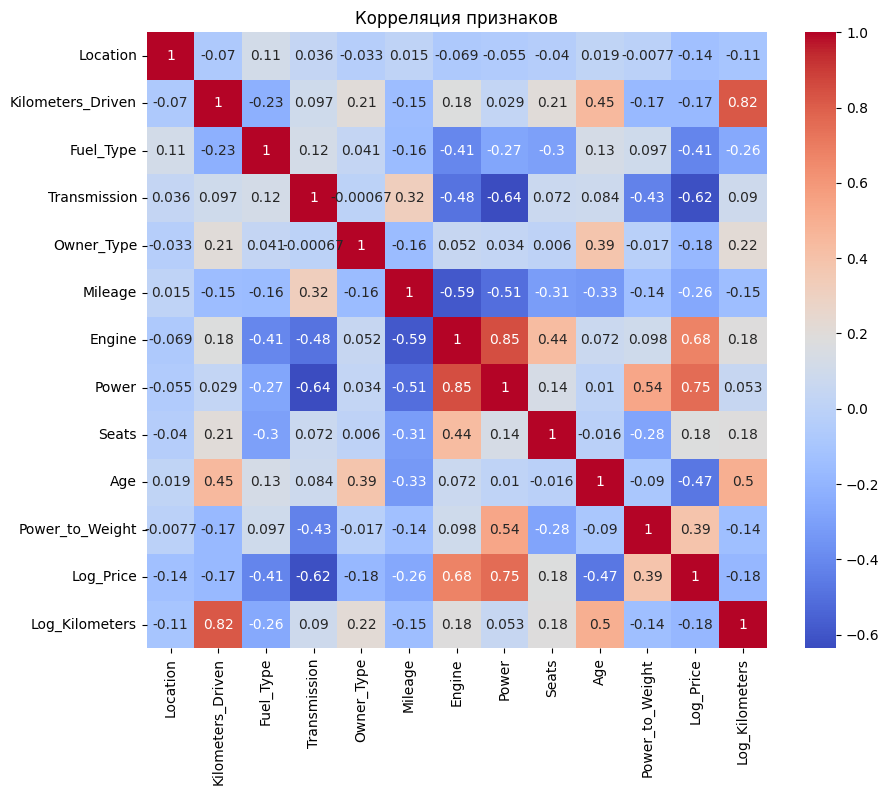

In [45]:
# Визуализация корреляций
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Корреляция признаков')
plt.show()


scaler = StandardScaler()
X = scaler.fit_transform(X)

### Создаётся модель  и настраиваются её гиперпараметры с помощью GridSearchCV, чтобы найти оптимальные параметры.

In [46]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Определение модели линейной регрессии
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Создание модели решающего дерева
dt = DecisionTreeRegressor(random_state=42)

# Настройка гиперпараметров для GridSearchCV
param_grid = {
    'max_depth': [5, 10, 15, 20, None],  # Глубина дерева
    'min_samples_split': [2, 5, 10, 20],  # Минимальное количество образцов для разделения узла
    'min_samples_leaf': [1, 2, 5, 10],  # Минимальное количество образцов в листе
}

# Поиск лучших гиперпараметров с использованием GridSearchCV
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',  # Используем MAE в качестве метрики
    cv=5,  # 5-кратная кросс-валидация
    n_jobs=-1,  # Используем все доступные ядра
    verbose=2
)

# Обучение модели с подбором гиперпараметров
grid_search.fit(X_train, y_train)

# Вывод лучших параметров
best_params = grid_search.best_params_
print("Лучшие параметры:", best_params)

# Обучение лучшей модели с найденными гиперпараметрами
best_model = grid_search.best_estimator_

# Прогнозирование на валидационных данных
y_pred = best_model.predict(X_val)

# Обратное преобразование прогнозов и целевой переменной
y_pred_original = np.expm1(y_pred)  
y_val_original = np.expm1(y_val)

# Оценка качества модели в оригинальном масштабе
mae_original = mean_absolute_error(y_val_original, y_pred_original)
mse_original = mean_squared_error(y_val_original, y_pred_original)
r2_original = r2_score(y_val_original, y_pred_original)

print("MAE:", mae_original)
print("MSE:", mse_original)
print("R² :", r2_original)



Fitting 5 folds for each of 80 candidates, totalling 400 fits
Лучшие параметры: {'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 20}
MAE: 1.7250776634485918
MSE: 9.811797171726589
R² : 0.8764317706961717


## ***Выводы***
### После улучшения модели были достигнуты значительные улучшения в качестве предсказаний. Средняя абсолютная ошибка (MAE) снизилась с 2.19 до 1.73, что представляет собой улучшение примерно на 21%. Среднеквадратичная ошибка (MSE) сократилась с 28.61 до 9.81, что указывает на уменьшение больших отклонений в предсказаниях на 66%. Коэффициент детерминации (R²) вырос с 0.767 до 0.876, что демонстрирует улучшение способности модели объяснять вариативность данных на 11%. Эти улучшения стали возможны благодаря оптимизации гиперпараметров решающего дерева, включая max_depth, min_samples_leaf и min_samples_split, что позволило найти оптимальный баланс между переобучением и недообучением. Итоговый результат показывает, что модель после настройки значительно точнее и надежнее в задаче прогнозирования.

## **Собственная имплементация решающего дерева**

#### Алгоритм представляет собой реализацию дерева решений для задачи регрессии. На этапе обучения (fit) дерево строится рекурсивно с использованием метода _build_tree. Для каждого узла производится проверка условий остановки (достигнута максимальная глубина, недостаточное количество выборок для разделения или значения целевой переменной однородны). Если условия остановки не выполняются, алгоритм ищет лучшее разбиение данных по признакам и порогам с минимизацией среднеквадратичной ошибки (MSE), используя метод _best_split. После нахождения оптимального разбиения данные делятся на левое и правое поддеревья, которые строятся рекурсивно.
#### На этапе предсказания (predict) каждый объект проходит через дерево с помощью метода _traverse_tree. На каждом уровне проверяется, какой дочерний узел выбрать, пока алгоритм не достигнет листа, где возвращается среднее значение целевой переменной для выборок, попавших в этот узел. Такой подход позволяет строить модель, которая адаптируется к структуре данных, минимизируя ошибки предсказания.

In [50]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


class Node:
    """Класс для представления узла в дереве."""
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        self.feature_index = feature_index  # Индекс признака для разбиения
        self.threshold = threshold  # Порог для разбиения
        self.left = left  # Левое поддерево
        self.right = right  # Правое поддерево
        self.value = value  # Значение узла (для листьев)


class CustomDecisionTreeRegressor:
    """Собственная реализация дерева решений для задачи регрессии."""
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth  # Максимальная глубина дерева
        self.min_samples_split = min_samples_split  # Минимальное количество выборок для разделения
        self.min_samples_leaf = min_samples_leaf  # Минимальное количество выборок в листе
        self.root = None  # Корневой узел дерева

    def fit(self, X, y):
        """Обучение дерева решений на данных."""
        self.root = self._build_tree(X, y)

    def predict(self, X):
        """Предсказание на основе построенного дерева."""
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _build_tree(self, X, y, depth=0):
        """Рекурсивное построение дерева."""
        n_samples, n_features = X.shape
        # Остановочные условия
        if n_samples < self.min_samples_split or depth == self.max_depth or len(np.unique(y)) == 1:
            return Node(value=np.mean(y))

        # Поиск наилучшего разбиения
        best_feature, best_threshold = self._best_split(X, y)
        if best_feature is None:
            return Node(value=np.mean(y))

        # Разделение данных
        left_indices = X[:, best_feature] <= best_threshold
        right_indices = X[:, best_feature] > best_threshold
        left = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right = self._build_tree(X[right_indices], y[right_indices], depth + 1)
        return Node(feature_index=best_feature, threshold=best_threshold, left=left, right=right)

    def _best_split(self, X, y):
        """Поиск лучшего разбиения по признакам."""
        n_samples, n_features = X.shape
        best_feature = None
        best_threshold = None
        best_mse = float("inf")

        for feature_index in range(n_features):
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                # Разделение данных
                left_indices = X[:, feature_index] <= threshold
                right_indices = X[:, feature_index] > threshold
                if len(y[left_indices]) < self.min_samples_leaf or len(y[right_indices]) < self.min_samples_leaf:
                    continue

                # Вычисление MSE
                mse = self._calculate_mse(y, left_indices, right_indices)
                if mse < best_mse:
                    best_mse = mse
                    best_feature = feature_index
                    best_threshold = threshold

        return best_feature, best_threshold

    def _calculate_mse(self, y, left_indices, right_indices):
        """Вычисление MSE для разбиения."""
        left_mean = np.mean(y[left_indices]) if len(y[left_indices]) > 0 else 0
        right_mean = np.mean(y[right_indices]) if len(y[right_indices]) > 0 else 0

        left_mse = np.mean((y[left_indices] - left_mean) ** 2) if len(y[left_indices]) > 0 else 0
        right_mse = np.mean((y[right_indices] - right_mean) ** 2) if len(y[right_indices]) > 0 else 0

        return left_mse * len(y[left_indices]) + right_mse * len(y[right_indices])

    def _traverse_tree(self, x, node):
        """Рекурсивный обход дерева для предсказания."""
        if node.value is not None:
            return node.value
        if x[node.feature_index] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)



    # Загрузка и подготовка данных
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
data = pd.read_csv("cars.csv")
data['Mileage'] = data['Mileage'].str.replace(' kmpl', '').str.replace(' km/kg', '').astype(float)
data['Engine'] = data['Engine'].str.replace(' CC', '').astype(float)
data['Power'] = data['Power'].str.replace(' bhp', '').replace('null', np.nan).astype(float)

imputer = SimpleImputer(strategy='mean')
data['Mileage'] = imputer.fit_transform(data[['Mileage']])
data['Engine'] = imputer.fit_transform(data[['Engine']])
data['Power'] = imputer.fit_transform(data[['Power']])
data['Seats'] = data['Seats'].fillna(data['Seats'].mode()[0])

categorical_columns = ['Fuel_Type', 'Transmission', 'Owner_Type', 'Location']
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

data = data.drop(['Unnamed: 0', 'Name', 'New_Price'], axis=1)

X = data.drop('Price', axis=1).values
y = data['Price'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Обучение модели
tree = CustomDecisionTreeRegressor(max_depth=10, min_samples_split=5, min_samples_leaf=2)
tree.fit(X_train, y_train)

    # Предсказания
y_pred = tree.predict(X_val)

    # Оценка качества
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("R²:", r2)


MAE: 2.192971744401568
MSE: 28.755146835062632
R²: 0.7663313378539636


## ***Выводы***
### Встроенная модель решающего дерева и собственная реализация показали схожие результаты. MAE составил 2.189 для встроенной модели и 2.193 для собственной (разница 0.004). MSE оказался немного ниже у встроенной модели — 28.614 против 28.755 (разница 0.141), что указывает на чуть лучшее поведение при крупных ошибках. R² практически идентичен: 0.767 у встроенной модели и 0.766 у собственной (разница 0.001). В целом, обе модели работают почти одинаково, а небольшие преимущества встроенной модели несущественны.

## **Собственная имплементация решающего дерева с улучшенным бейзлайном**

In [52]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import pandas as pd


class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value


class CustomDecisionTreeRegressor:
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.root = None

    def fit(self, X, y):
        self.root = self._build_tree(X, y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        if n_samples < self.min_samples_split or depth == self.max_depth or len(np.unique(y)) == 1:
            return Node(value=np.mean(y))

        best_feature, best_threshold = self._best_split(X, y)
        if best_feature is None:
            return Node(value=np.mean(y))

        left_indices = X[:, best_feature] <= best_threshold
        right_indices = X[:, best_feature] > best_threshold
        left = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right = self._build_tree(X[right_indices], y[right_indices], depth + 1)
        return Node(feature_index=best_feature, threshold=best_threshold, left=left, right=right)

    def _best_split(self, X, y):
        n_samples, n_features = X.shape
        best_feature = None
        best_threshold = None
        best_mse = float("inf")

        for feature_index in range(n_features):
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                left_indices = X[:, feature_index] <= threshold
                right_indices = X[:, feature_index] > threshold
                if len(y[left_indices]) < self.min_samples_leaf or len(y[right_indices]) < self.min_samples_leaf:
                    continue

                mse = self._calculate_mse(y, left_indices, right_indices)
                if mse < best_mse:
                    best_mse = mse
                    best_feature = feature_index
                    best_threshold = threshold

        return best_feature, best_threshold

    def _calculate_mse(self, y, left_indices, right_indices):
        left_mean = np.mean(y[left_indices]) if len(y[left_indices]) > 0 else 0
        right_mean = np.mean(y[right_indices]) if len(y[right_indices]) > 0 else 0

        left_mse = np.mean((y[left_indices] - left_mean) ** 2) if len(y[left_indices]) > 0 else 0
        right_mse = np.mean((y[right_indices] - right_mean) ** 2) if len(y[right_indices]) > 0 else 0

        return left_mse * len(y[left_indices]) + right_mse * len(y[right_indices])

    def _traverse_tree(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature_index] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)


def grid_search_custom_tree(X_train, y_train, X_val, y_val):
    param_grid = {
        'max_depth': [5, 10, 15, 20, None],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 5, 10],
    }
    best_params = None
    best_score = float('inf')

    for max_depth in param_grid['max_depth']:
        for min_samples_split in param_grid['min_samples_split']:
            for min_samples_leaf in param_grid['min_samples_leaf']:
                tree = CustomDecisionTreeRegressor(
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    min_samples_leaf=min_samples_leaf
                )
                tree.fit(X_train, y_train)
                y_pred = tree.predict(X_val)
                mae = mean_absolute_error(y_val, y_pred)

                if mae < best_score:
                    best_score = mae
                    best_params = {
                        'max_depth': max_depth,
                        'min_samples_split': min_samples_split,
                        'min_samples_leaf': min_samples_leaf
                    }

    return best_params, best_score



    # Загрузка и подготовка данных
data = pd.read_csv("cars.csv")
data['Mileage'] = data['Mileage'].str.replace(' kmpl', '').str.replace(' km/kg', '').astype(float)
data['Engine'] = data['Engine'].str.replace(' CC', '').astype(float)
data['Power'] = data['Power'].str.replace(' bhp', '').replace('null', np.nan).astype(float)

imputer = SimpleImputer(strategy='mean')
data['Mileage'] = imputer.fit_transform(data[['Mileage']])
data['Engine'] = imputer.fit_transform(data[['Engine']])
data['Power'] = imputer.fit_transform(data[['Power']])
data['Seats'] = data['Seats'].fillna(data['Seats'].mode()[0])

categorical_columns = ['Fuel_Type', 'Transmission', 'Owner_Type', 'Location']
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

data = data.drop(['Unnamed: 0', 'Name', 'New_Price'], axis=1)

X = data.drop('Price', axis=1).values
y = data['Price'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Поиск лучших гиперпараметров
best_params, best_score = grid_search_custom_tree(X_train, y_train, X_val, y_val)
print("Лучшие параметры:", best_params)
print("Лучшая MAE:", best_score)

    # Обучение модели с лучшими параметрами
best_tree = CustomDecisionTreeRegressor(
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf']
)
best_tree.fit(X_train, y_train)

    # Оценка качества
y_pred = best_tree.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("R²:", r2)


Лучшие параметры: {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 5}
Лучшая MAE: 2.0484706785629054
MAE: 2.0484706785629054
MSE: 20.314663527711218
R²: 0.8349199788234425


## ***Выводы***
### Встроенная модель решающего дерева значительно лучше собственной реализации. Она показывает меньшую MAE (1.725 против 2.048), почти в два раза меньшую MSE (9.812 против 20.315) и более высокий R² (0.876 против 0.835). Это связано с использованием более глубокой структуры дерева (глубина 20 против 10) и оптимальных параметров (min_samples_split=20 против 2)